<a href="https://colab.research.google.com/github/alrz199/autoencoders/blob/main/vae_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing variational autoencoder using FashionMnist data

In [ ]:
!pip --quiet install pytorch_lightning pytorch_forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor()])
# Fashion mnist
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

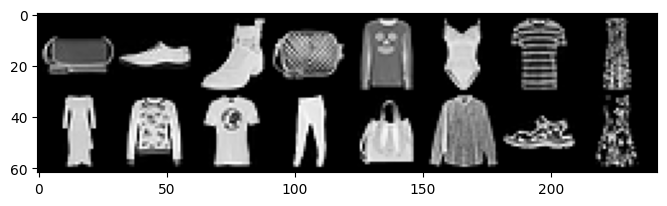

In [ ]:
def imshow(img):
    npimg = img.numpy()
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images[0:16]))

In [ ]:
import pytorch_lightning as pl
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate=0.005
class nnn(pl.LightningModule):
    def __init__(self):
        super().__init__()
        latent_dim = 16
        input_dim = 784
        hidden_dim = 200
        c_hid = 2
        act_fn = nn.LeakyReLU
        # our encoder is comprised of conv2 layers and one linear layer at the ned
        self.encoder = nn.Sequential(
            nn.Conv2d(1, c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(4*7*7, latent_dim))

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
            )

    def encode(self, x):
# get mean and variance from the encoder
        x = self.encoder(x)
        mean, sd = self.mean_layer(x), self.logvar_layer(x)
        return mean, sd

    def reparameterization(self, mean, sd):
# sample from normal distribution
        epsilon = torch.randn_like(sd).to(device)
        z = mean + sd*epsilon
        return z

    def forward(self, x):
        mean, sd = self.encode(x)
        z = self.reparameterization(mean, sd)
        x_hat = self.decoder(z)
        return x_hat, mean, sd

    def loss_function(self, x, x_hat, mean, sd):
# we have assumed that z comes from a normal distribution, so we can use the simplified version of the loss
        x = x.view(-1,28*28)
        x_hat = x_hat.view(-1,28*28)
        loss = F.mse_loss(x_hat,x)
        KLD = - 0.5 * torch.sum(1+ sd - mean.pow(2) - sd.exp())
        return loss + KLD

    def training_step(self, batch, batch_idx):
        x, y = batch
        out, mu, sd =self.forward(x)
        loss = self.loss_function(x, out, mu, sd)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
  #   def configure_optimizers(self):
  #       optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        # return {
        # "optimizer": optimizer,
        # "lr_scheduler": {
        #   "scheduler":  torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)}}


In [ ]:
# Initialize a trainer
from pytorch_lightning import  Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="my_model")
model=nnn()
trainer = Trainer(
    accelerator="auto",
    max_epochs=20)

# Train the model ⚡
trainer.fit(model, train_loader)
print('Finished Training')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | encoder      | Sequential | 3.4 K 
1 | mean_layer   | Linear     | 34    
2 | logvar_layer | Linear     | 34    
3 | decoder      | Sequential | 161 K 
--------------------------------------------
164 K     Trainable params
0         Non-trainable params
164 K     Total params
0.658     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Finished Training


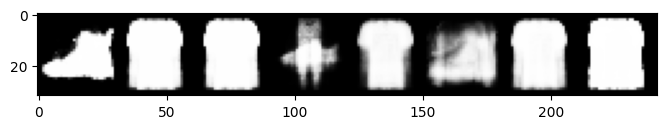

In [ ]:
# let's sample from a normal distribution and show the results
def generate_digit(mean, var):
    z_sample = torch.distributions.Normal(mean, var).rsample()
    x_decoded = model.decoder(z_sample)
    imshow(torchvision.utils.make_grid(x_decoded.view(-1,1,28,28)))
generate_digit(torch.zeros(8, 2),torch.ones(8, 2)*0.1)